In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report,auc
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report,make_scorer,precision_recall_curve
import numpy as np

In [28]:
data = pd.read_csv('/Users/jagan/Documents/coding/projects/fraud-detection-system/data/processed/merged_ieee_cis.csv')

In [ ]:
cat_cols = data.select_dtypes(include='object').columns
cat_cols

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [30]:
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

In [31]:
print(data.dtypes[cat_cols])

ProductCD        int64
card4            int64
card6            int64
P_emaildomain    int64
R_emaildomain    int64
M1               int64
M2               int64
M3               int64
M4               int64
M5               int64
M6               int64
M7               int64
M8               int64
M9               int64
id_12            int64
id_15            int64
id_16            int64
id_23            int64
id_27            int64
id_28            int64
id_29            int64
id_30            int64
id_31            int64
id_33            int64
id_34            int64
id_35            int64
id_36            int64
id_37            int64
id_38            int64
DeviceType       int64
DeviceInfo       int64
dtype: object


In [32]:
data.dtypes.value_counts().head(434)

float64    399
int64       35
Name: count, dtype: int64

In [33]:
data.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [34]:

cat_cols = data.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns to encode: {cat_cols}")


for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

print(data[cat_cols].dtypes)

Categorical columns to encode: []
Series([], dtype: object)


In [35]:
feature_cols = [col for col in data.columns if col not in ['isFraud']]
X = data[feature_cols]
y = data['isFraud']

In [36]:
X["TransactionAmt_log"] = np.log1p(X["TransactionAmt"])

In [37]:
X["DT_M"] = X["TransactionDT"] / (60 * 60 * 24 * 30)
X["DT_W"] = X["TransactionDT"] / (60 * 60 * 24 * 7)
X["DT_D"] = X["TransactionDT"] / (60 * 60 * 24)
X["DT_hour"] = (X["TransactionDT"] / 3600) % 24

In [38]:
for col in ["card1", "card2", "addr1", "DeviceInfo", "id_30", "id_31"]:
    if col in X.columns:
        freq = X[col].value_counts(dropna=False)
        X[col + "_freq"] = X[col].map(freq)

In [39]:
X["TransactionAmt_bin"] = pd.qcut(X["TransactionAmt"], 10, duplicates="drop").cat.codes

In [40]:
X["card1_amt_mean"] = X.groupby("card1")["TransactionAmt"].transform("mean")
X["card1_amt_std"] = X.groupby("card1")["TransactionAmt"].transform("std")
X["card1_trans_count"] = X.groupby("card1")["TransactionID"].transform("count")

In [50]:
X = X.select_dtypes(include=[np.number]).fillna(-999)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [55]:

scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Correct scale_pos_weight: {scale_pos_weight_value}")


model = xgb.XGBClassifier(
    n_estimators=1200,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric="aucpr",
    random_state=42,
    tree_method="hist"
)




Correct scale_pos_weight: 27.580278281911674


In [56]:
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [57]:
y_proba = model.predict_proba(X_val)[:, 1] 

In [58]:
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

PR AUC: 0.7931


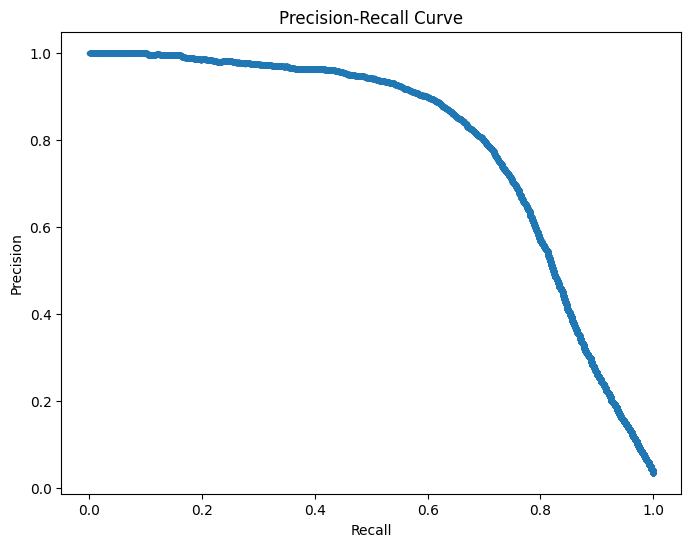

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [60]:
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold = {best_threshold:.3f}, F1 = {f1_scores[best_idx]:.3f}")

Best Threshold = 0.779, F1 = 0.747


In [61]:
y_pred_custom = (y_proba >= best_threshold).astype(int)

In [62]:
print("Classification Report (Custom Threshold):")
print(classification_report(y_val, y_pred_custom, digits=4))

Classification Report (Custom Threshold):
              precision    recall  f1-score   support

           0     0.9891    0.9938    0.9914    113975
           1     0.8022    0.6985    0.7468      4133

    accuracy                         0.9834    118108
   macro avg     0.8956    0.8461    0.8691    118108
weighted avg     0.9826    0.9834    0.9829    118108

